# Computational modeling : RL algorithms in a virtual environment

Question : under very low amounts of evidence, how do human sample a complex action space ? Can we infer some form of structure in this exploration ? Can Active Inference provide some answers regarding the mechanistic processes behind it ?



First, we grab the data corresponding to the experiment we're interested in (here, experiment 002). We also remove the subjects that either had technical issues or had very suspicious results. *(we should provide a clear rule on subject exclusion here, maybe based on action variance across all dimensions or reaction times ?).*

In [1]:
# Import the needed packages 
# 
# 1/ the usual suspects
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

from jax.tree_util import tree_map
import jax.random as jr


# 2/ Useful functions from our package :
from actynf.jaxtynf.jax_toolbox import _normalize,_jaxlog
from actynf.jaxtynf.jax_toolbox import random_split_like_tree

# To make nice plots : 
from simulate.plot_trajectory import plot_training


# The simulated environment :
from simulate.hmm_weights import behavioural_process # The environment is statically defined by its HMM matrices
from simulate.generate_observations_full_actions import TrainingEnvironment,run_loop,generate_synthetic_data

# The methods to predict actions, compute the log-likelihoods and fit the models :
from simulate.compute_likelihood_full_actions import compute_predicted_actions,compute_loglikelihood
from simulate.compute_likelihood_full_actions import fit_mle_agent,fit_map_agent
from functools import partial


# The artificial agents : 
from agents_full_actions import random_agent
from agents_omega import ltQL_agent
from simulate.hmm_weights import basic_latent_model # For the active inference model


c:\Users\annic\OneDrive\Bureau\MainPhD\code\behavioural_exp_code\exploit_results_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
NTRIALS = 30
T = 11

# ENVIRONMENTAL CONSTANTS :
N_FEEDBACK_OUTCOMES = 6
TRUE_FEEDBACK_STD = 0.025#175
GRID_SIZE = (7,7)
START_COORD = [[5,1],[5,2],[4,1]]
END_COORD = [0,6]

# The weights of the HMM environment
(a,b,c,d,e,u),fb_vals = behavioural_process(GRID_SIZE,START_COORD,END_COORD,N_FEEDBACK_OUTCOMES,TRUE_FEEDBACK_STD)

rngkey = jax.random.PRNGKey(np.random.randint(0,10))
ENVIRONMENT = TrainingEnvironment(rngkey,a,b,c,d,e,u,T)

No = N_FEEDBACK_OUTCOMES

# Depending on the dimensions of the problem :
models_constants = {
    "angle" : {
        "N_actions" : 9,
        "N_outcomes" : No,
    },
    "distance" : {
        "N_actions" : 4,
        "N_outcomes" : No,
    },
    "position" : {
        "N_actions" : 9,
        "N_outcomes" : No,
    }
}

Behaviour of one ltQL agent with controlability estimation :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
Trial 20
Trial 21
Trial 22
Trial 23
Trial 24
Trial 25
Trial 26
Trial 27
Trial 28
Trial 29
[Array(0., dtype=float32), Array(0.00833333, dtype=float32), Array(0.01625, dtype=float32), Array(0.02877084, dtype=float32), Array(0.03641563, dtype=float32), Array(0.04292818, dtype=float32), Array(0.0498651, dtype=float32), Array(0.05713018, dtype=float32), Array(0.06013951, dtype=float32), Array(0.06440011, dtype=float32), Array(0.06643844, dtype=float32)]
[Array(0.06311652, dtype=float32), Array(0.06367035, dtype=float32), Array(0.06090886, dtype=float32), Array(0.05357657, dtype=float32), Array(0.06658059, dtype=float32), Array(0.0650674, dtype=float32), Array(0.08001192, dtype=float32), Array(0.08189341, dtype=float32), Array(0.08175094, dtype=float32), Array(0.07830372, dtype=float32), Array(0.07204815, dtype=float32)]
[Ar

C:\Users\annic\AppData\Local\Temp\ipykernel_19024\4272880557.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(2,Nactions+1,figsize=(15,5))


[Array(0.1536924, dtype=float32), Array(0.15730664, dtype=float32), Array(0.1437124, dtype=float32), Array(0.1345966, dtype=float32), Array(0.12538092, dtype=float32), Array(0.11467008, dtype=float32), Array(0.12039322, dtype=float32), Array(0.13816236, dtype=float32), Array(0.13782784, dtype=float32), Array(0.1380784, dtype=float32), Array(0.16418989, dtype=float32)]
[Array(0.1559804, dtype=float32), Array(0.15994774, dtype=float32), Array(0.17155269, dtype=float32), Array(0.19451661, dtype=float32), Array(0.21166627, dtype=float32), Array(0.21240573, dtype=float32), Array(0.20597252, dtype=float32), Array(0.1974006, dtype=float32), Array(0.1993781, dtype=float32), Array(0.1948343, dtype=float32), Array(0.17836206, dtype=float32)]
[Array(0.16944395, dtype=float32), Array(0.15223026, dtype=float32), Array(0.1584557, dtype=float32), Array(0.14716429, dtype=float32), Array(0.15474844, dtype=float32), Array(0.14948082, dtype=float32), Array(0.16199768, dtype=float32), Array(0.1728553, dty

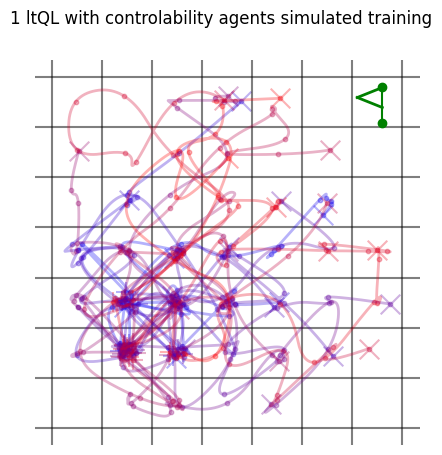

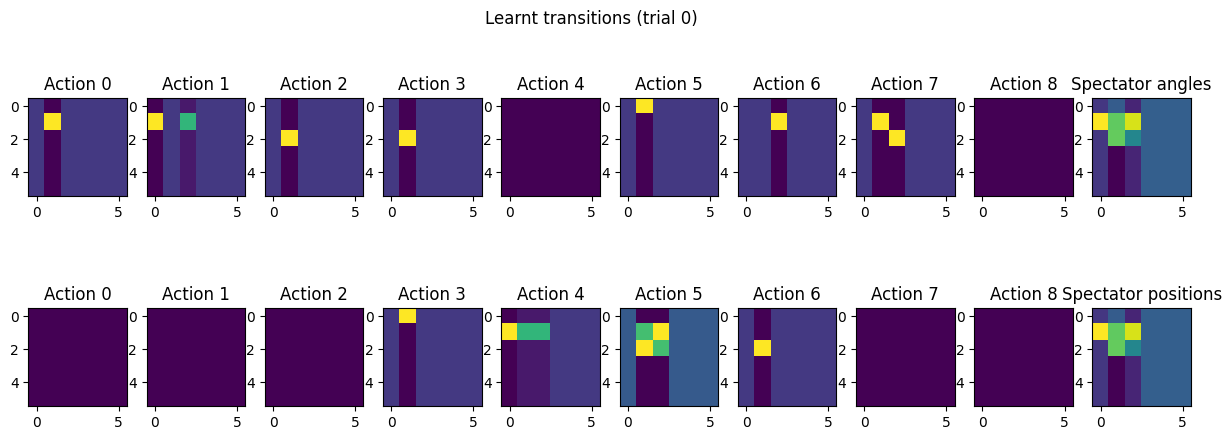

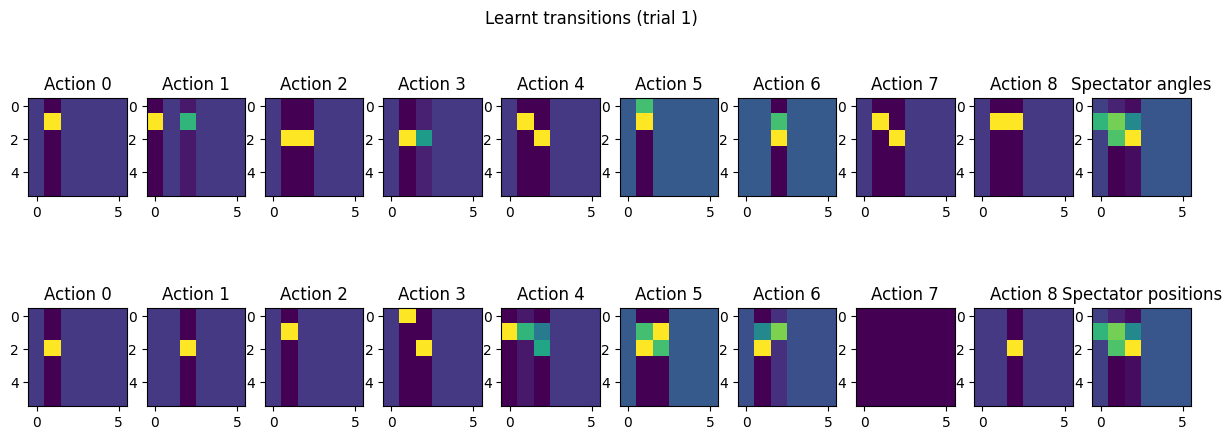

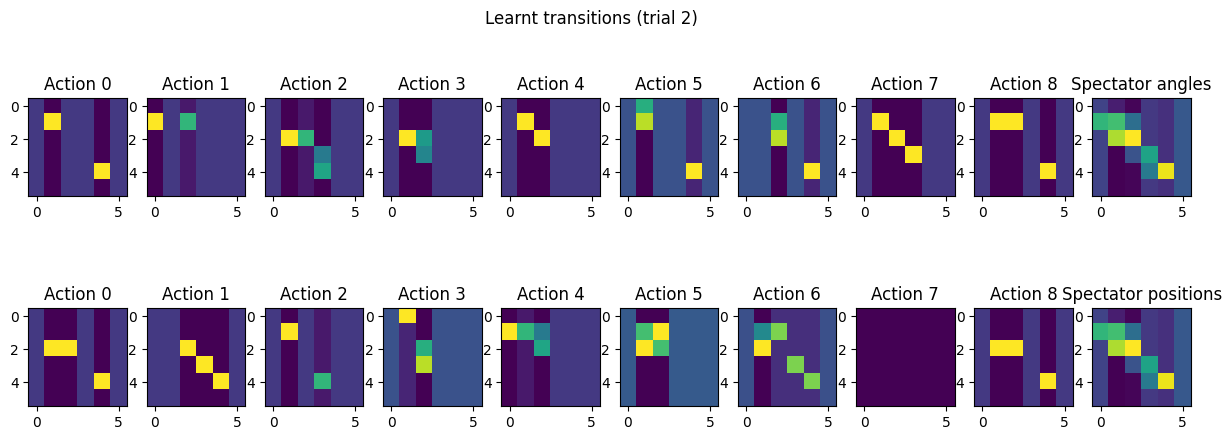

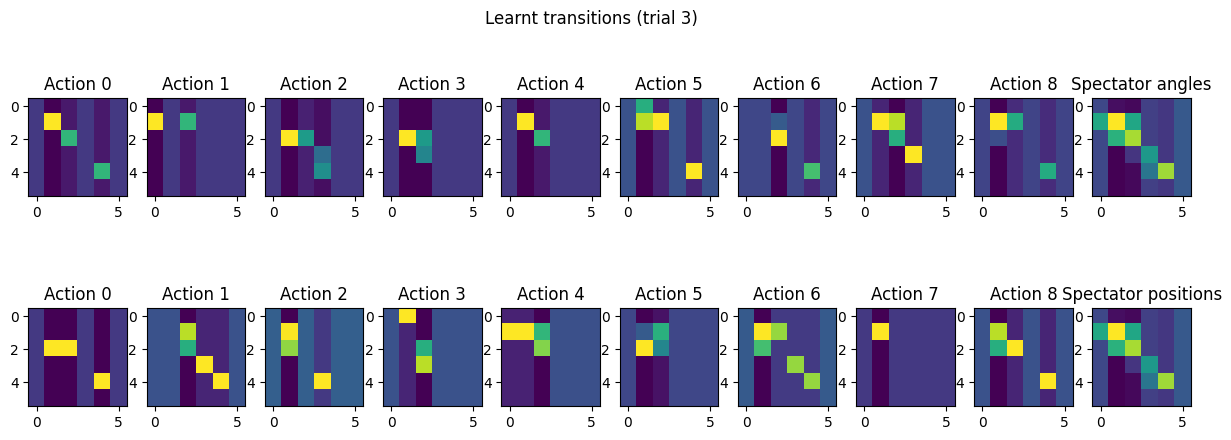

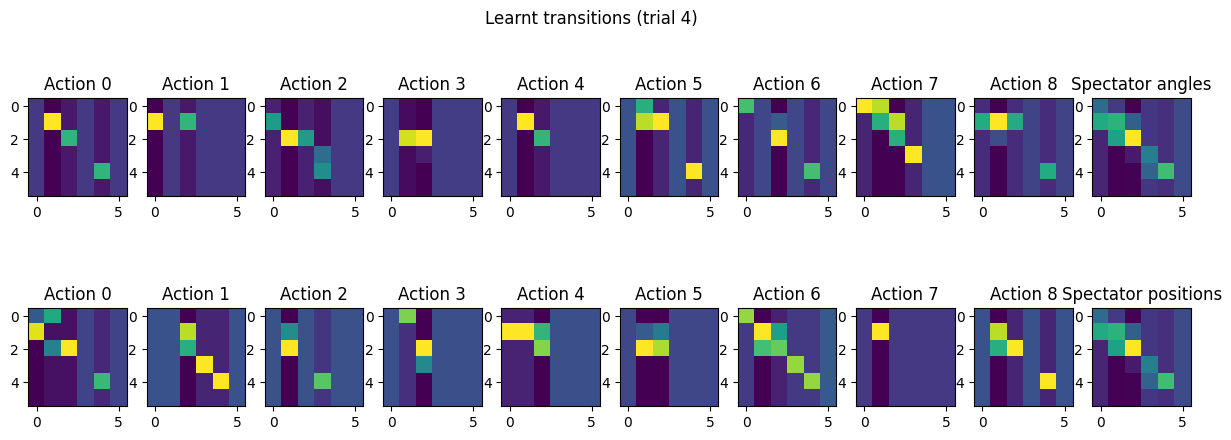

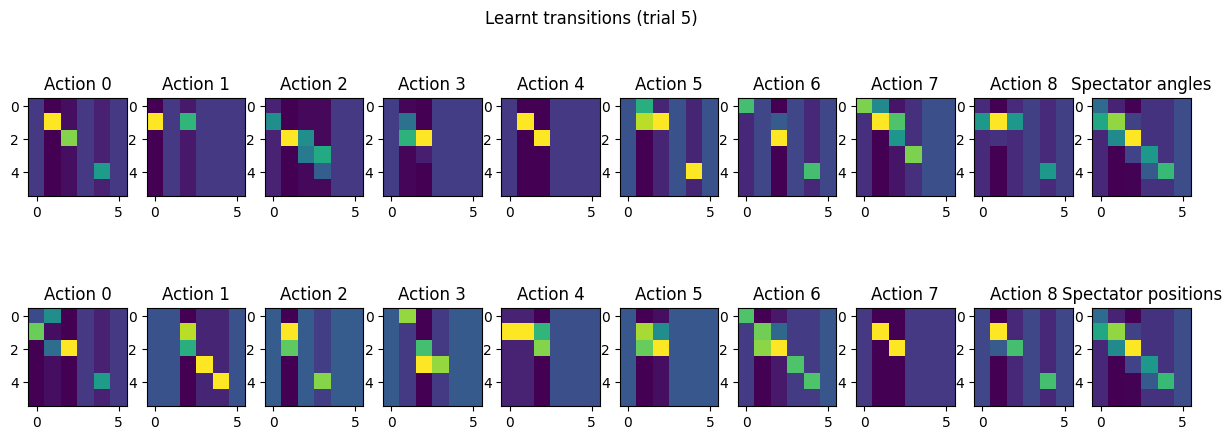

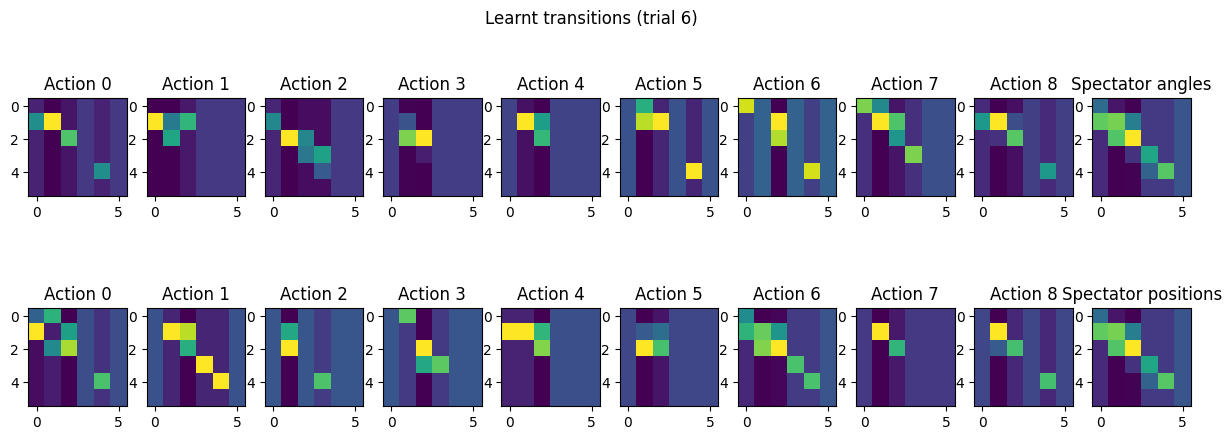

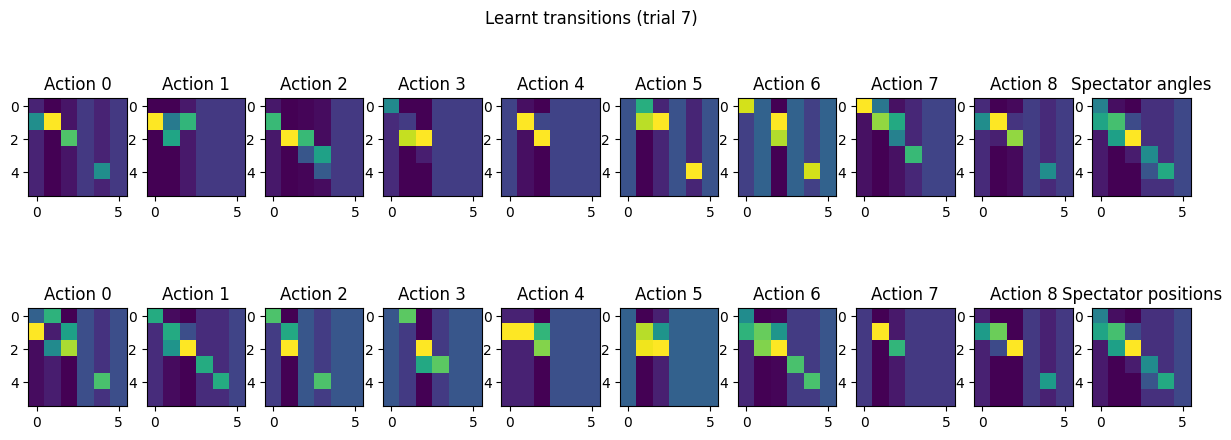

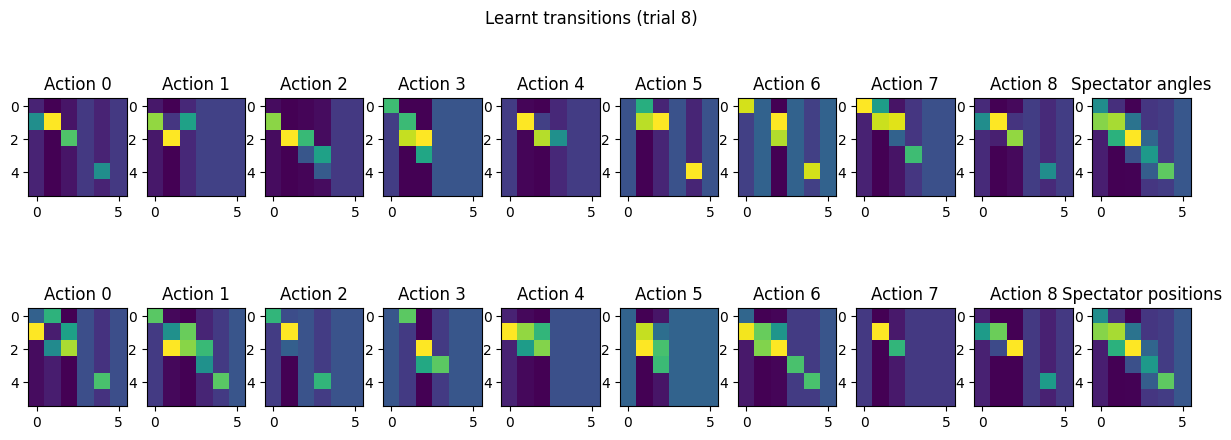

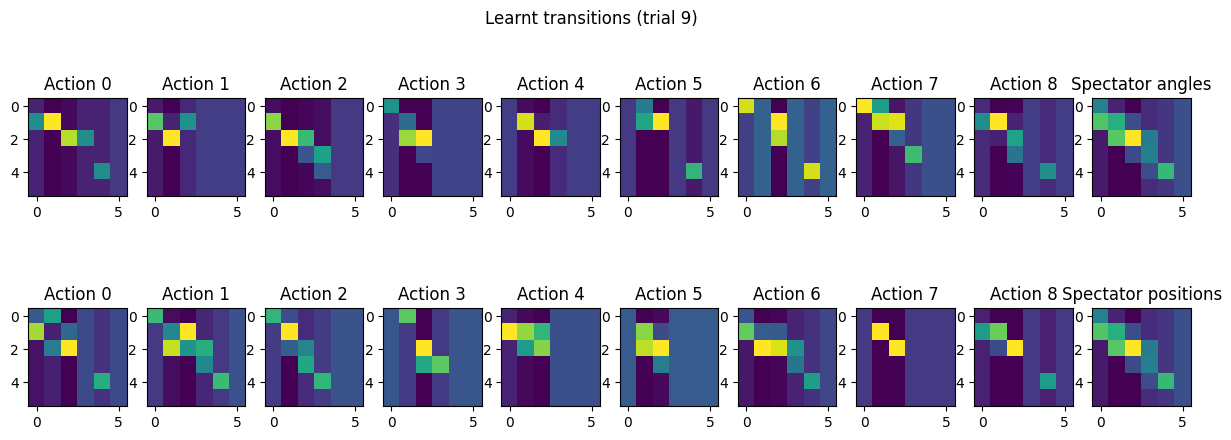

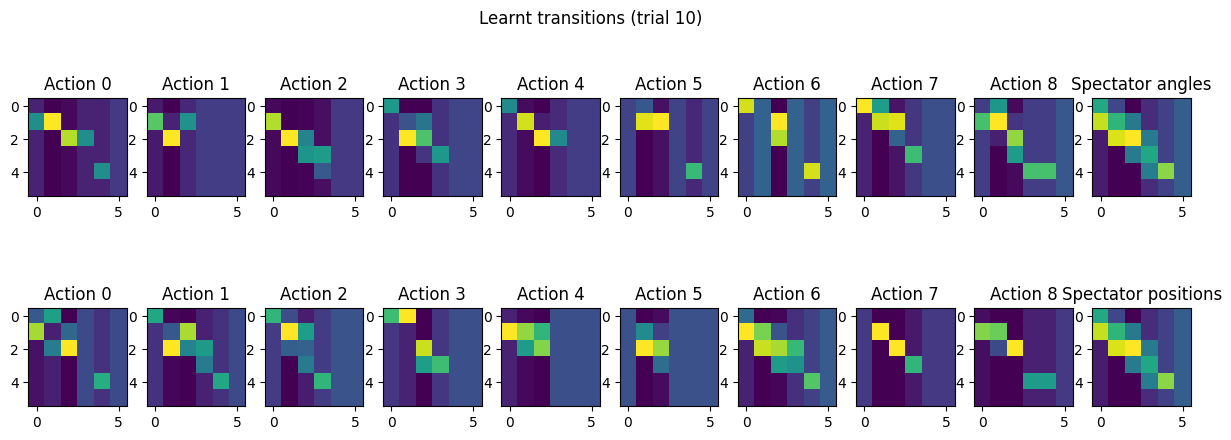

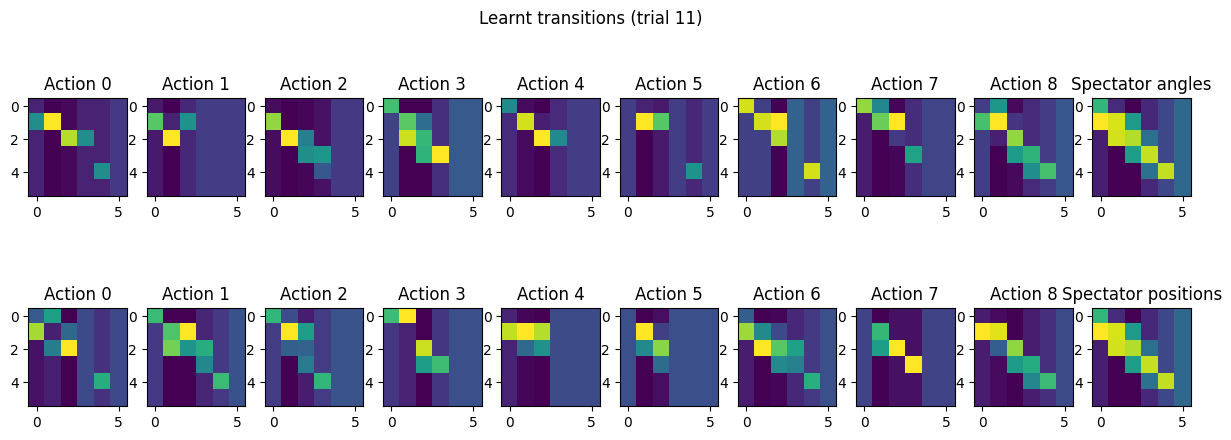

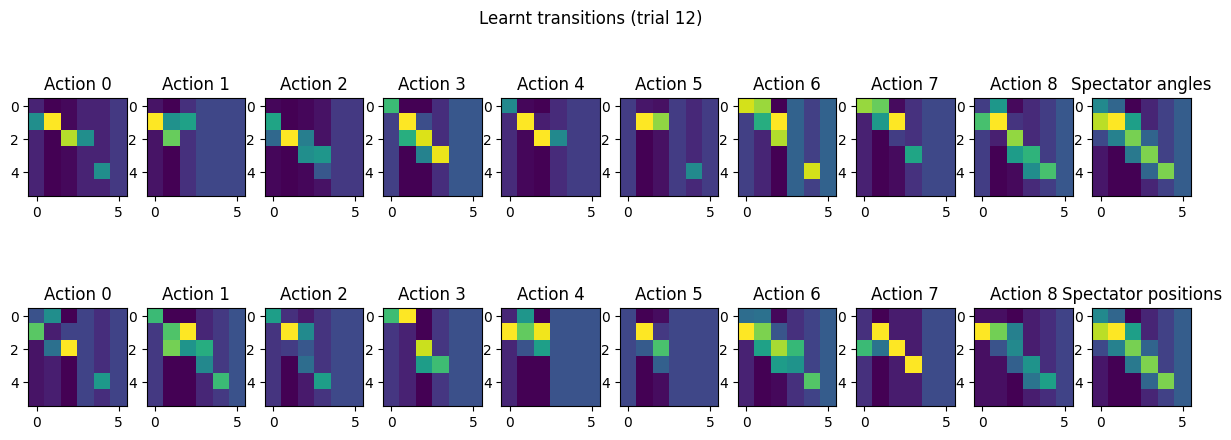

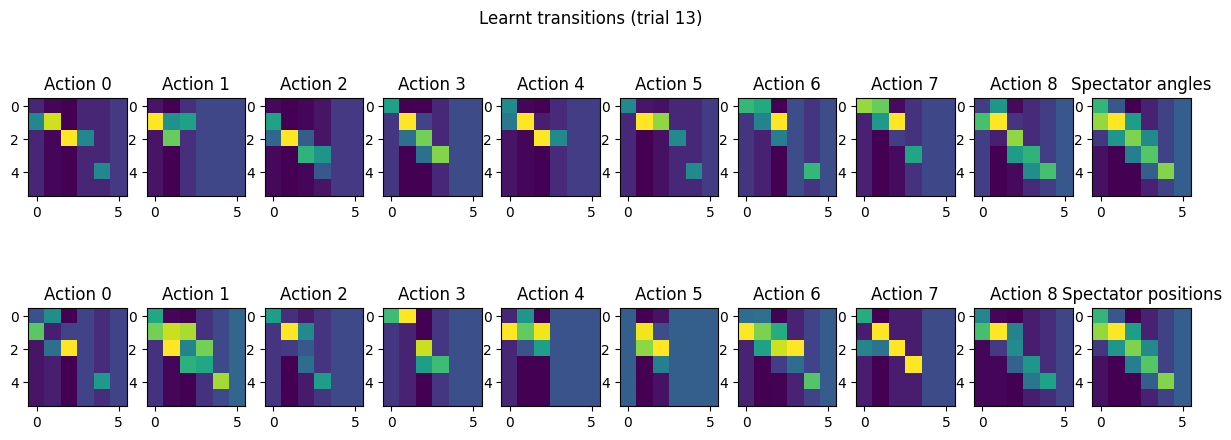

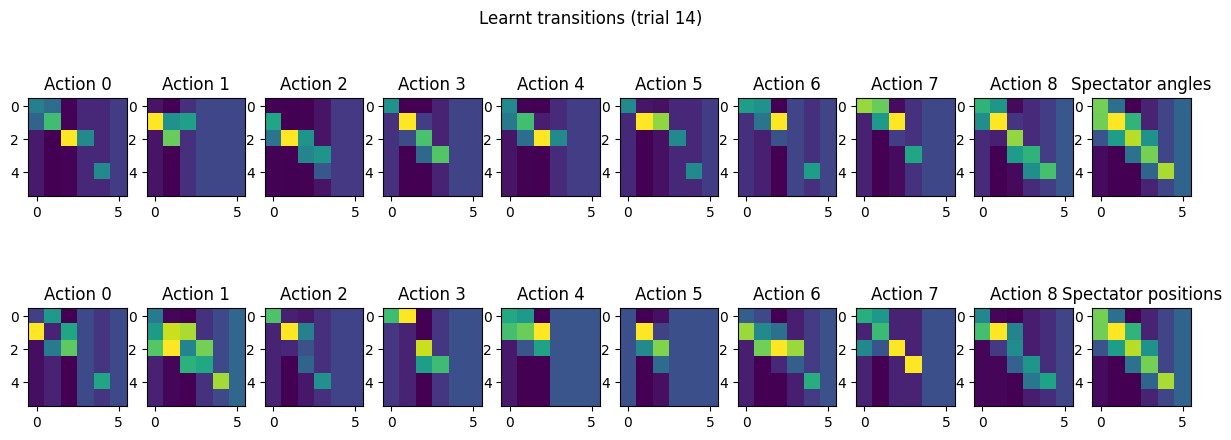

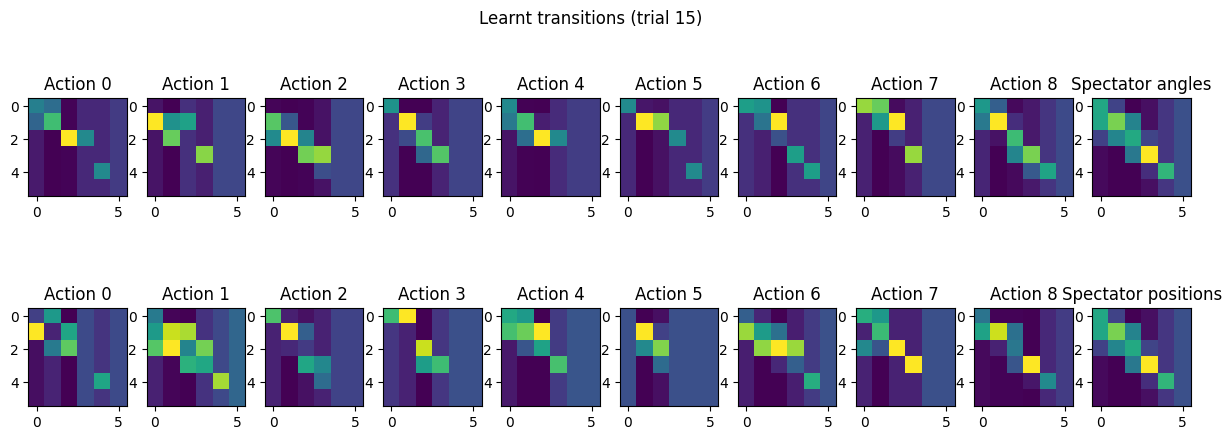

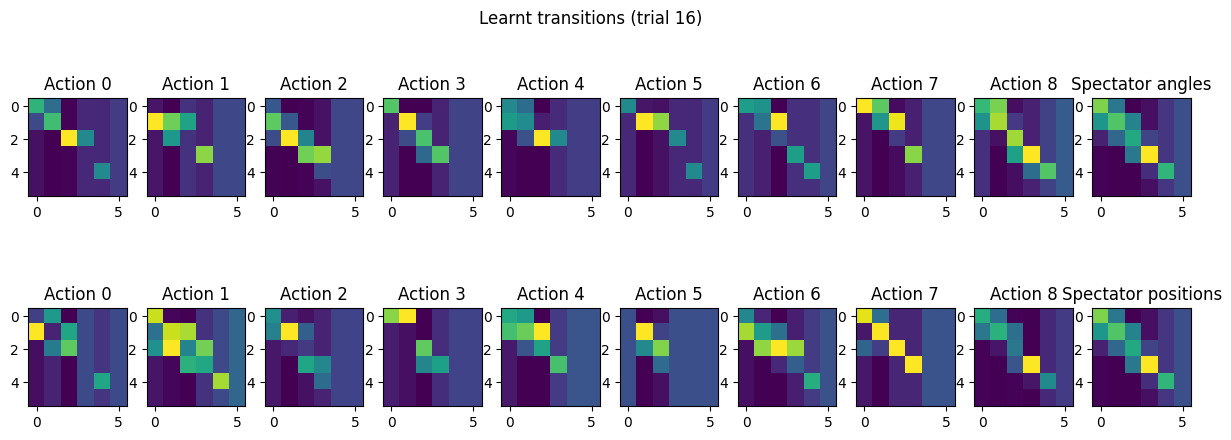

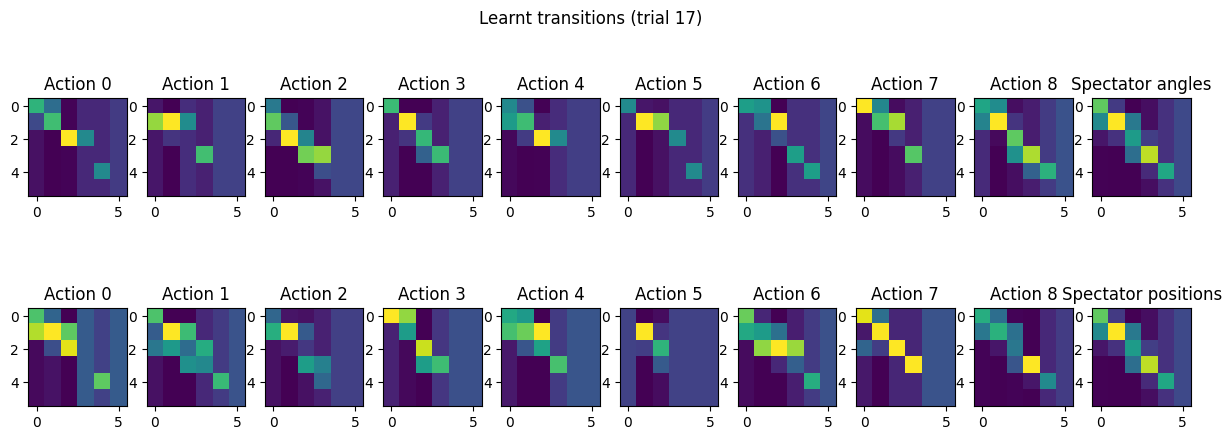

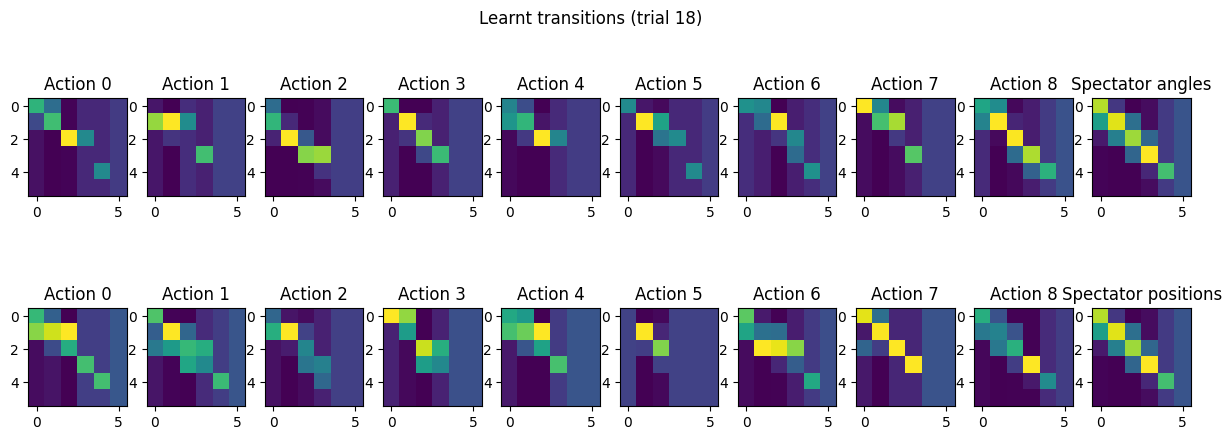

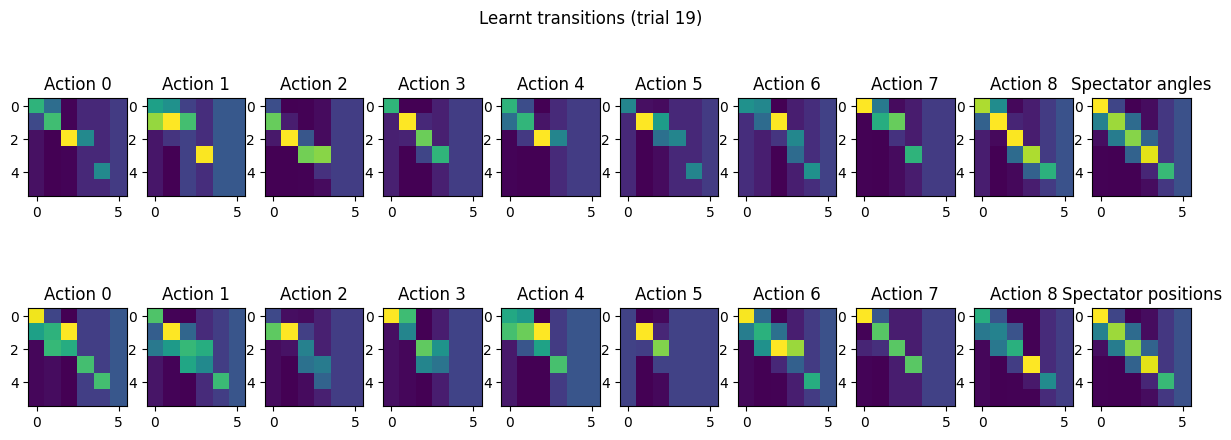

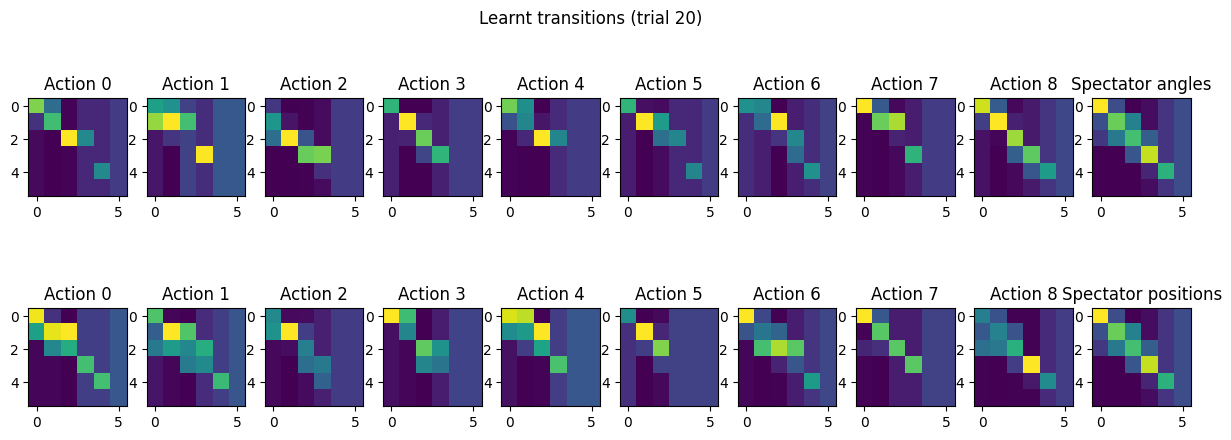

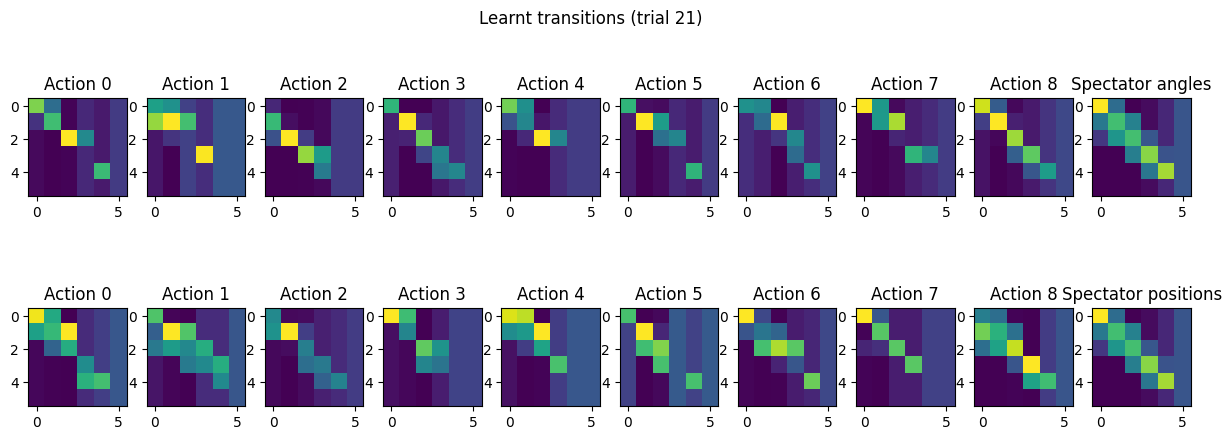

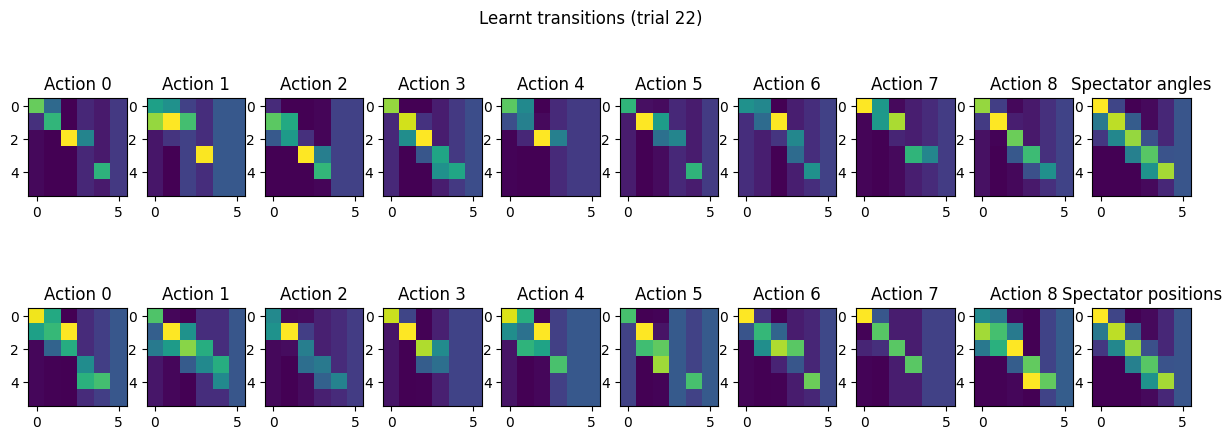

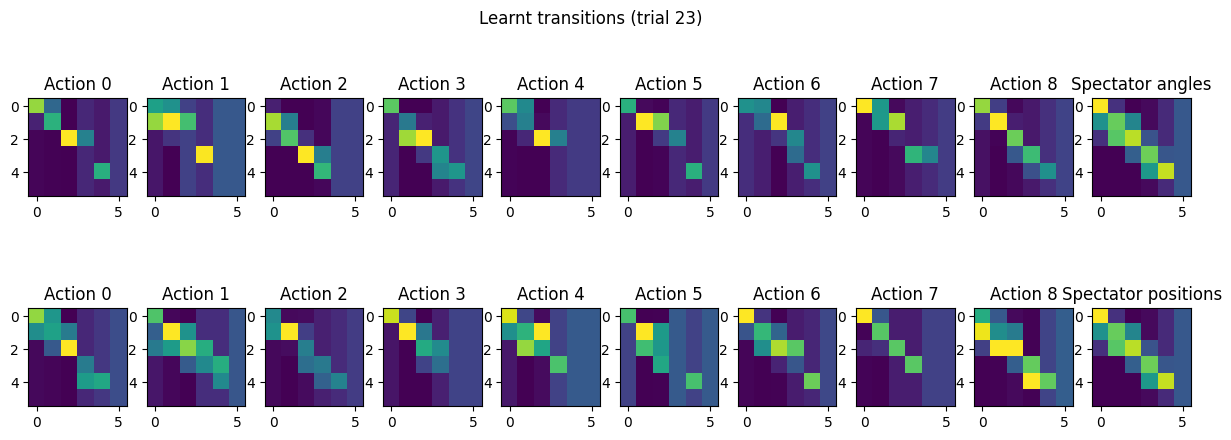

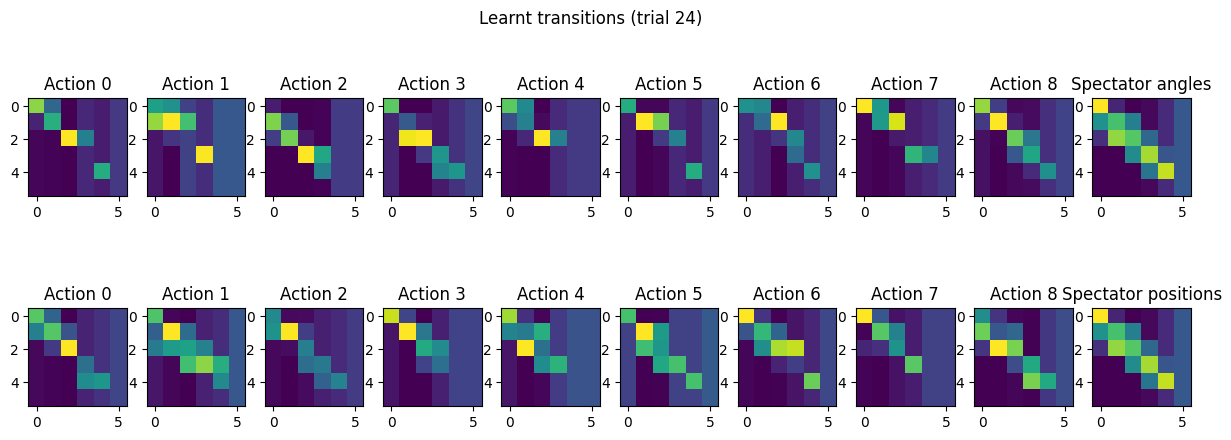

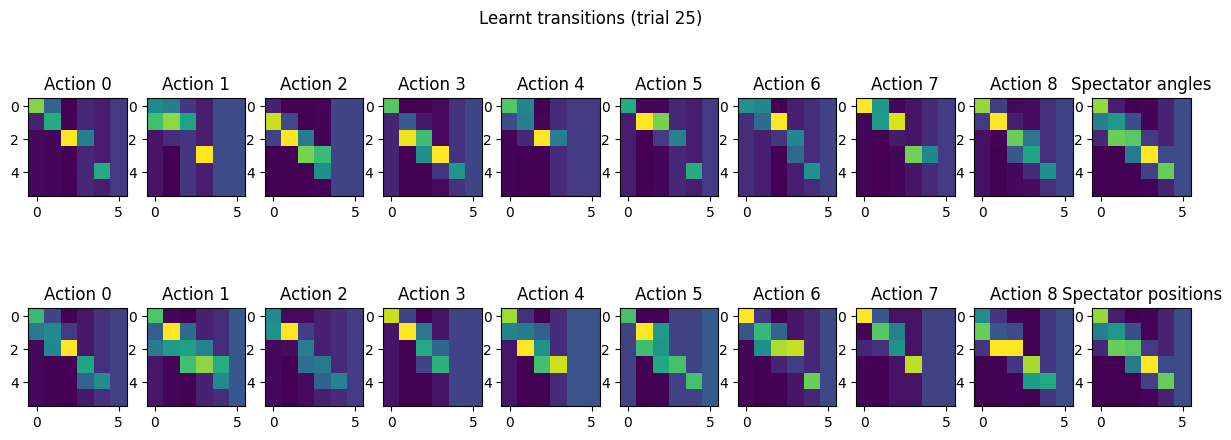

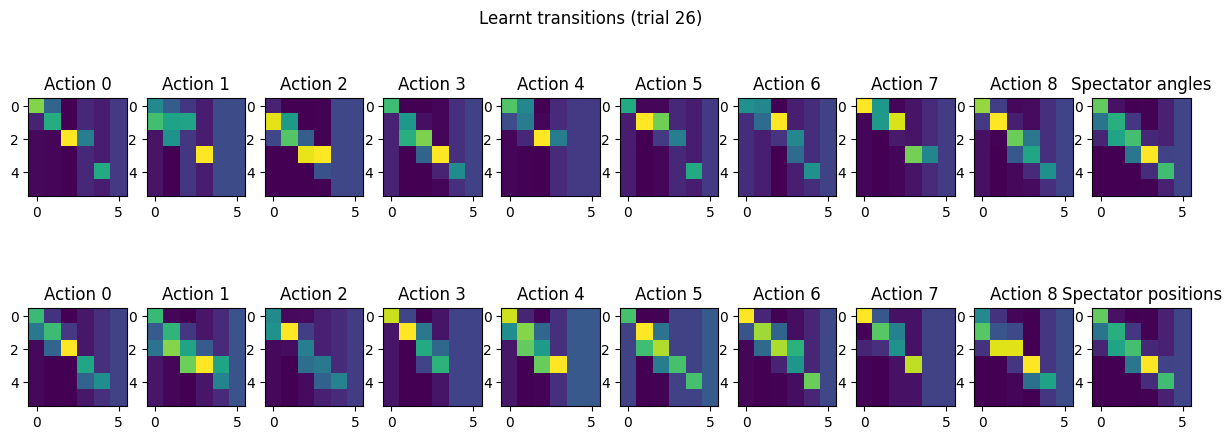

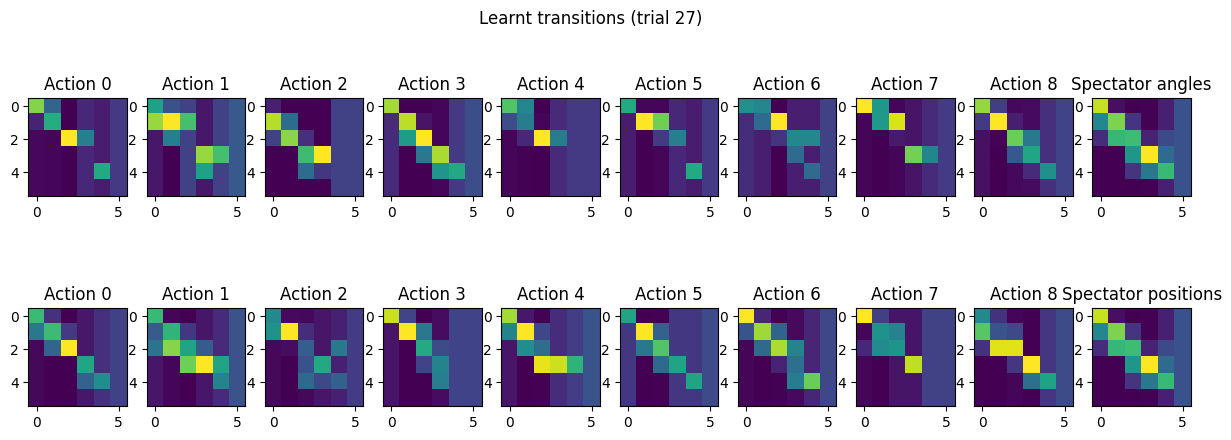

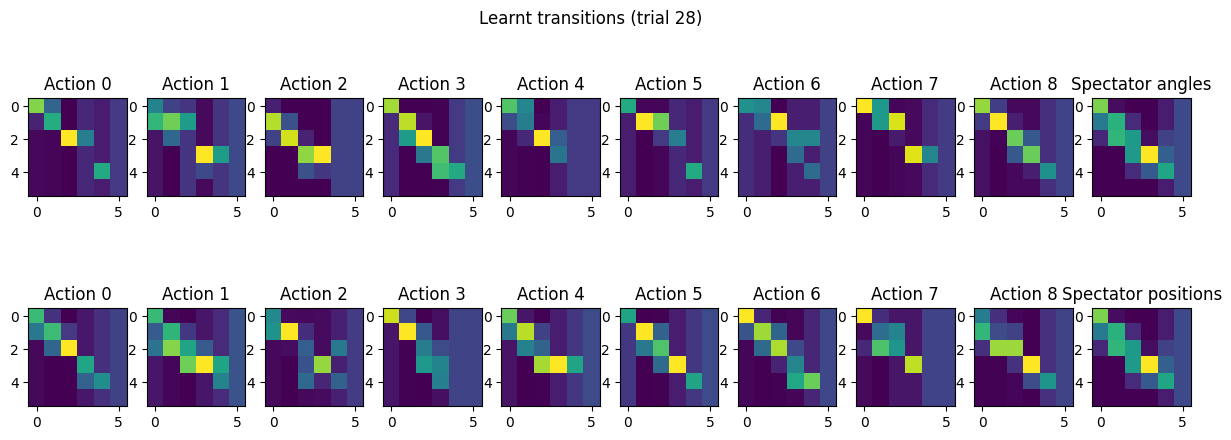

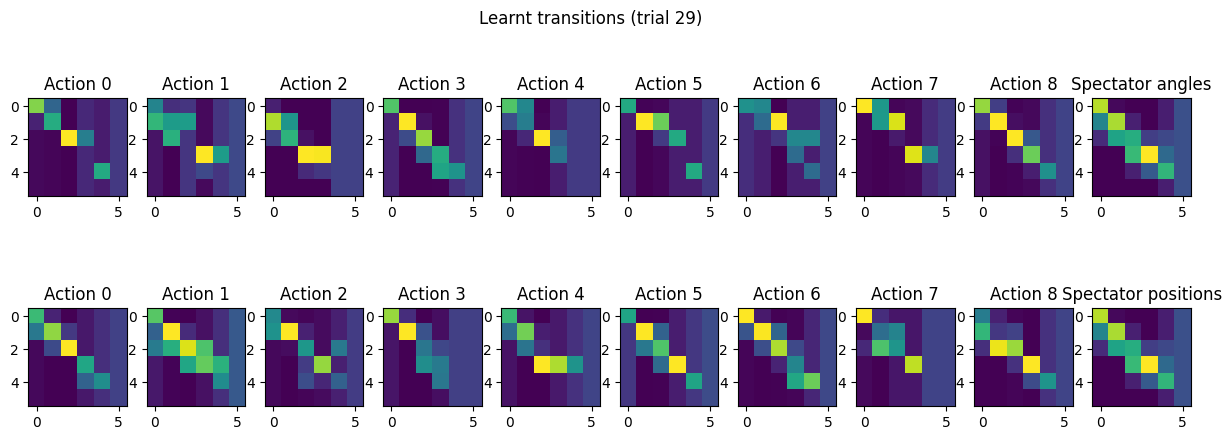

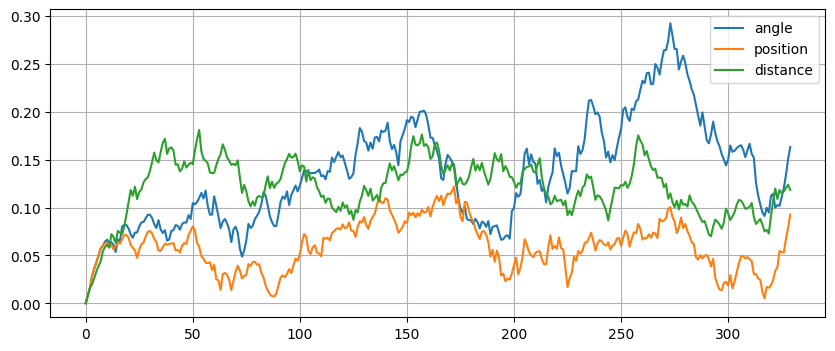

In [6]:

GT_ltql_agent_hyperparameters = {
    "angle":{
        "alpha_+":0.5,
        "alpha_-":0.5,
        "beta" : 20.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3,
        "spectator_alpha" : 0.1,
        "omega_alpha" : 0.05,
        "omega_beta" : 0.0
    },
    "position":{
        "alpha_+":0.5,
        "alpha_-":0.5,
        "beta" :20.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3,
        "spectator_alpha" : 0.1,
        "omega_alpha" : 0.05
    },
    "distance":{
        "alpha_+":0.5,
        "alpha_-":0.5,
        "beta" : 20.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3,
        "spectator_alpha" : 0.1,
        "omega_alpha" : 0.05
    }
}

# n_trials = 20
# SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,ltQL_agent(GT_ltql_agent_hyperparameters,models_constants),
#                                          n_trials=n_trials,seed = 1,verbose = True)
# (formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


SEED = np.random.randint(1000)
params_final,training_hist = run_loop(ENVIRONMENT,ltQL_agent(GT_ltql_agent_hyperparameters,models_constants),SEED,NTRIALS)
simulated_states = np.array(training_hist["env_states"])

fig,ax = plt.subplots(figsize= (5,5))
fig.suptitle("1 ltQL with controlability agents simulated training")
plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)



controlability_estimates = []
for trial in range(len(training_hist["states"])):
    (new_qt,new_ck,new_B,new_Bss,new_omega,vect_action_selected,current_stimuli) = training_hist["states"][trial]
    
    print(new_omega["angle"])
    b = new_B["angle"][-1]
    Nactions = b.shape[-1]
    
    # Plot the evolution of transition / action mappings :
    fig,axs = plt.subplots(2,Nactions+1,figsize=(15,5))
    fig.suptitle("Learnt transitions (trial {})".format(trial))
    
    b = new_B["angle"][-1]
    for k in range(Nactions):
        ax = axs[0,k]
        ax.set_title("Action {}".format(k))
        im = ax.imshow(_normalize(b[...,k])[0])
    ax = axs[0,k+1]
    ax.set_title("Spectator angles")
    bss = new_Bss["angle"][-1]
    ax.imshow(_normalize(bss)[0])
    
    b = new_B["position"][-1]
    for k in range(Nactions):
        ax = axs[1,k]
        ax.set_title("Action {}".format(k))
        im = ax.imshow(_normalize(b[...,k])[0])
    ax = axs[1,k+1]
    ax.set_title("Spectator positions")
    bss = new_Bss["position"][-1]
    ax.imshow(_normalize(bss)[0])
    # fig,ax = plt.subplots(1,figsize=(5,5))
    # fig.suptitle("Learnt Q-table (timestep {})".format(t))
    # im = ax.imshow(one_training_episode_qtables[t,...],cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    # ax.set_xlabel("State")
    # ax.set_xlabel("Action")
    # fig.colorbar(im)
    controlability_estimates.append(list(new_omega.values()))


flat_contr_est = np.swapaxes(np.array(controlability_estimates),1,2)
Nmod = flat_contr_est.shape[-1]
flat_contr_est = np.reshape(flat_contr_est,(-1,Nmod))
fig,ax=plt.subplots(figsize=(10,4))
for mod in range(Nmod):
    ax.plot(flat_contr_est[...,mod],label=list(new_omega.keys())[mod])
ax.grid()
ax.legend()

Example of behaviour simulated by a given model in the environment :

Trial 0


KeyError: 'spectator_alpha'

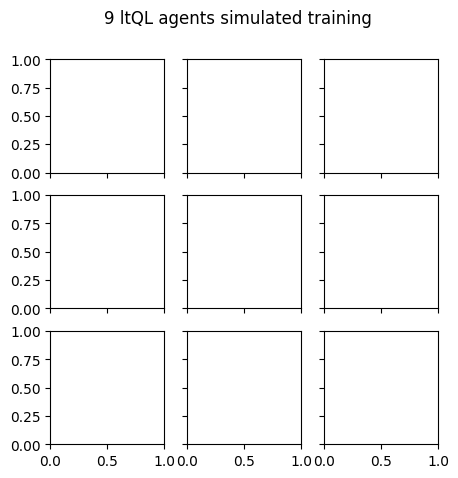

In [4]:
NTRIALS = 10
fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
fig.suptitle("9 ltQL agents simulated training")

ltql_agent_hyperparameters = {
    "angle":{
        "alpha_+":0.2,
        "alpha_-":0.2,
        "beta" : 30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3
    },
    "position":{
        "alpha_+":0.2,
        "alpha_-":0.2,
        "beta" :30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 0.0,
        "transition_alpha" : 0.3
    },
    "distance":{
        "alpha_+":0.2,
        "alpha_-":0.2,
        "beta" : 30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 0.0,
        "transition_alpha" : 0.3
    }
}

for ax in axs.reshape(-1): 
    # In : an agent based on some hyperparameters : 
    SEED = np.random.randint(1000)

    params_final,training_hist = run_loop(ENVIRONMENT,ltQL_agent(ltql_agent_hyperparameters,models_constants),SEED,NTRIALS)

    simulated_states = np.array(training_hist["env_states"])

    plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)


# # RW agent for comparison :
# rw_agent_hyperparameters ={
#     "angle":{
#         "alpha":0.5,
#         "beta" :40.0
#     },
#     "position":{
#         "alpha":0.3,
#         "beta" :4.0
#     },
#     "distance":{
#         "alpha":0.1,
#         "beta" :40.0
#     }
# }
# fig,axs = plt.subplots(3,3,sharex=True,sharey=True,figsize= (5,5))
# fig.suptitle("9 RW agents simulated training")
# for ax in axs.reshape(-1): 
#     # In : an agent based on some hyperparameters : 
#     SEED = np.random.randint(1000)

#     params_final,training_hist = run_loop(ENVIRONMENT,rw_agent(rw_agent_hyperparameters,models_constants),SEED,NTRIALS)

#     simulated_states = np.array(training_hist["env_states"])

#     plot_training(ax,simulated_states,GRID_SIZE,END_COORD,line_width=2,alpha=0.3)

Generate some synthetic data for the model we're interested in :

Trial 0
Trial 1
Trial 2
Trial 3
Trial 4
Trial 5
Trial 6
Trial 7
Trial 8
Trial 9
Trial 10
Trial 11
Trial 12
Trial 13
Trial 14
Trial 15
Trial 16
Trial 17
Trial 18
Trial 19
GT LL : 
{'angle': Array(-271.17383, dtype=float32), 'distance': Array(-223.41891, dtype=float32), 'position': Array(-429.30725, dtype=float32)}
(20, 11, 9, 10)


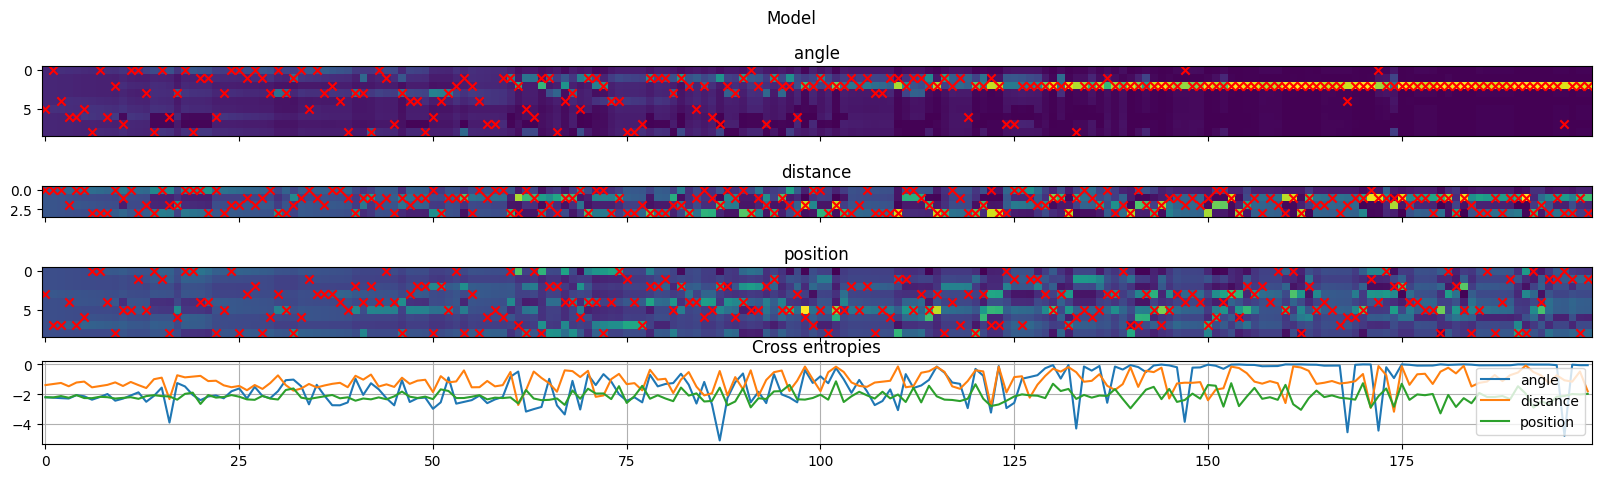

In [4]:

GT_ltql_agent_hyperparameters = {
    "angle":{
        "alpha_+":0.4,
        "alpha_-":0.6,
        "beta" : 30.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 5.0,
        "transition_alpha" : 0.3
    },
    "position":{
        "alpha_+":0.5,
        "alpha_-":0.5,
        "beta" :10.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3
    },
    "distance":{
        "alpha_+":0.5,
        "alpha_-":0.5,
        "beta" : 20.0,
        "alpha_ck" : 0.05,
        "beta_ck" : 2.0,
        "transition_alpha" : 0.3
    }
}

n_trials = 20
SYNTHETIC_DATA = generate_synthetic_data(ENVIRONMENT,ltQL_agent(GT_ltql_agent_hyperparameters,models_constants),
                                         n_trials=n_trials,seed = 1,verbose = True)
(formatted_stimuli,bool_stimuli,rewards,true_actions,tmtsp) = SYNTHETIC_DATA


# Optimal likelihood for the data (the best predictive power we should be able to achieve ):
lls,ces = compute_loglikelihood(SYNTHETIC_DATA,ltQL_agent(GT_ltql_agent_hyperparameters,models_constants),"sum")
final_parameters,predicted_actions,state_history = compute_predicted_actions(SYNTHETIC_DATA,ltQL_agent(GT_ltql_agent_hyperparameters,models_constants))
model_states,other_data = state_history
qt_history,ck_history,b_history,_,_ = model_states


# plt.imshow(np.reshape(ck_history["position"],(-1,9)))
fig,axs = plt.subplots(len(true_actions)+1,1,figsize=(n_trials,5),sharex=True)
fig.suptitle("Model")

for i,key in enumerate(predicted_actions.keys()):
    ax = axs[i]

    N_action_cat = true_actions[key].shape[-1]
    
    prediction_map = np.reshape(predicted_actions[key],(-1,N_action_cat))
    ax.set_title(key)    
    ax.imshow(prediction_map.T)
        
    N_timesteps  = prediction_map.shape[0]
    ax.scatter(np.arange(N_timesteps),np.argmax(true_actions[key],axis=-1),color="red",marker="x")

ax = axs[-1]
ax.set_title("Cross entropies")
for mod,series in ces.items():
    ax.plot(series.flatten(),label=mod)
ax.legend()
ax.grid()

print("GT LL : ")
print(lls)
print(qt_history["angle"].shape)

step 0, loss: Traced<ShapedArray(float32[])>with<BatchTrace(level=1/0)> with
  val = Array([2340.4988, 3423.7595, 3849.9443, 4798.9297, 2646.8215, 2918.923 ,
       7782.2725, 4611.886 , 4579.005 , 1126.5283, 7847.511 , 3982.5652,
       4672.6606, 4413.6045, 2036.2229, 2223.3198, 1240.8984, 4108.432 ,
       4645.0786, 2840.4248, 3152.5864, 3832.4622, 2869.8486, 1305.9829,
       3855.1099, 3724.1553, 5512.224 , 4931.0776, 6462.3027, 5001.9404,
       1420.1198, 5699.635 , 1053.671 , 3931.4058, 8062.9766, 1565.8684,
       4755.3325, 5856.735 , 7934.8164, 1729.6248, 1673.5452, 4457.2173,
       4219.587 , 1903.8269, 4781.8247, 4828.6733, 1287.3801, 1329.9546,
       3115.1501, 1138.8708, 4417.2354, 5393.8804, 4734.353 , 5233.714 ,
       4849.463 , 4579.6313, 5586.625 , 6834.177 , 2572.648 , 4952.0176,
       1112.301 , 1094.0449, 2544.7783, 6090.528 , 7728.991 , 2706.5396,
       1644.3552, 1856.8032, 1707.8285, 1217.3589, 2356.5518, 4480.8647,
       4458.6914, 2664.6077, 5802.1553,

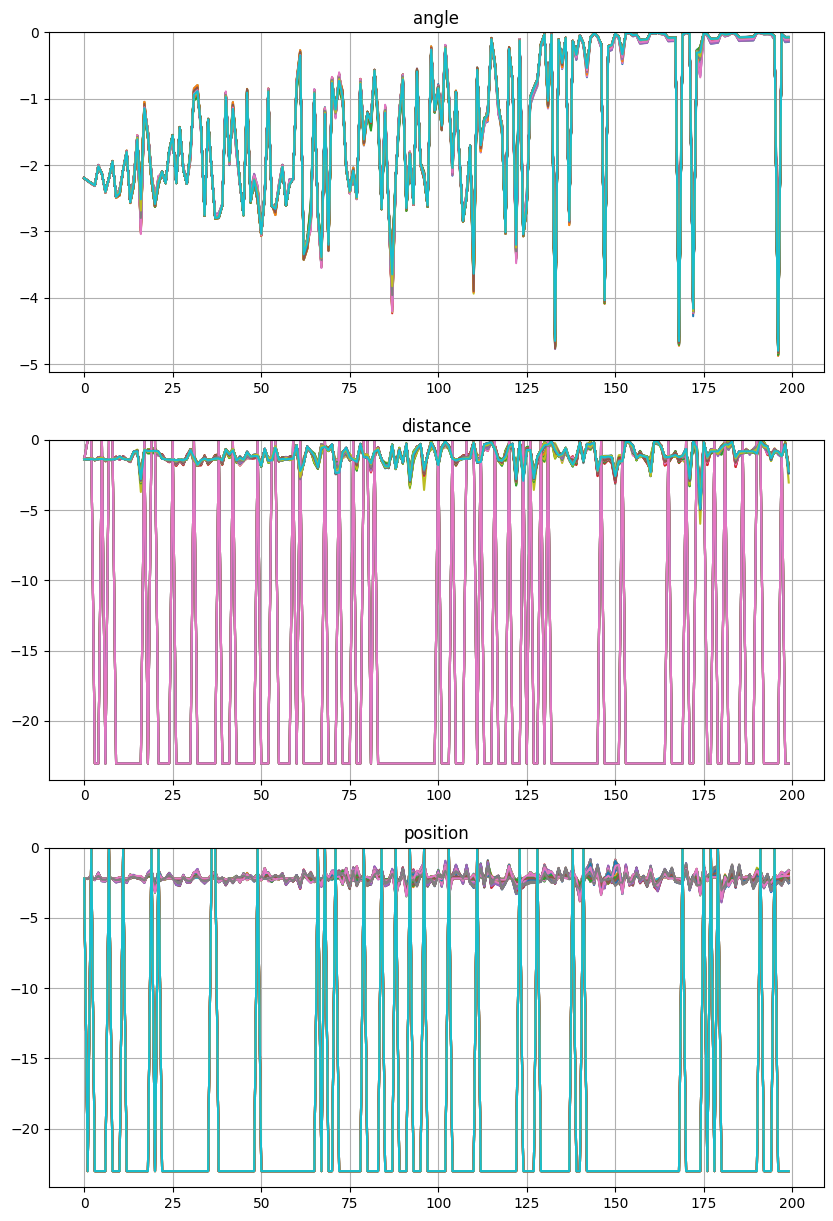

In [5]:


# Assuming uniform distributions for all parameters :
feature_range_tree ={
    "angle":{
        "alpha_+":jnp.array([-10,10]),
        "alpha_-":jnp.array([-10,10]),
        "beta" :jnp.array([0,10]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,10]),
        "transition_alpha":jnp.array([-10,10]),
    },
    "position":{
        "alpha_+":jnp.array([-10,10]),
        "alpha_-":jnp.array([-10,10]),
        "beta" :jnp.array([0,50]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,50]),
        "transition_alpha":jnp.array([-10,10])
    },
    "distance":{
        "alpha_+":jnp.array([-10,10]),
        "alpha_-":jnp.array([-10,10]),
        "beta" :jnp.array([0,50]),
        "alpha_ck":jnp.array([-10,10]),
        "beta_ck" :jnp.array([0,50]),
        "transition_alpha":jnp.array([-10,10])
    }
}
static_agent = partial(ltQL_agent,constants= models_constants)

all_fin_params,(gt_mle,all_losses,all_param_histories),encoding_function = fit_mle_agent(SYNTHETIC_DATA,
                            static_agent,feature_range_tree,jax.random.PRNGKey(0),
                            n_heads=100,num_steps=250,verbose=True)

final_lls,cross_entropies = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum"))(all_fin_params)

print(cross_entropies["angle"])
print(min(final_lls["angle"]))
print(max(final_lls["angle"]))
fig,axs = plt.subplots(3,1,figsize=(10,15))
for i,key in enumerate(cross_entropies.keys()):
    axs[i].set_title(key)
    for head in range(100):
        axs[i].plot(cross_entropies[key][head].flatten())
    axs[i].set_ylim(ymax=0.0)
    axs[i].grid()
plt.show()

Given the best match for subject parameters, we then reconstruct the evolution of model states / parameters across trials.

(100, 20, 11, 9)
(20, 11, 10, 10, 9)
(220, 9, 10)


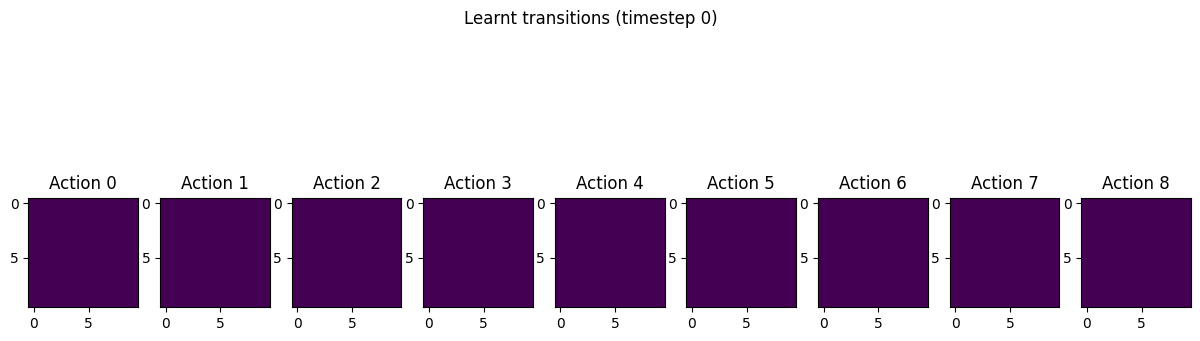

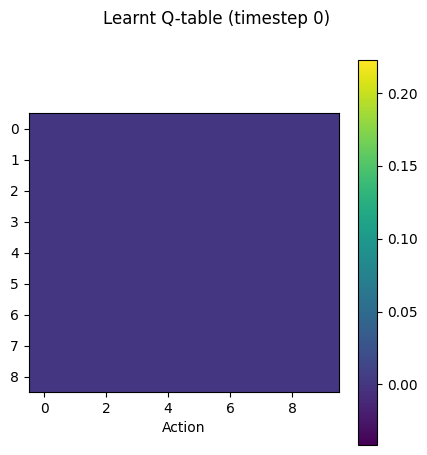

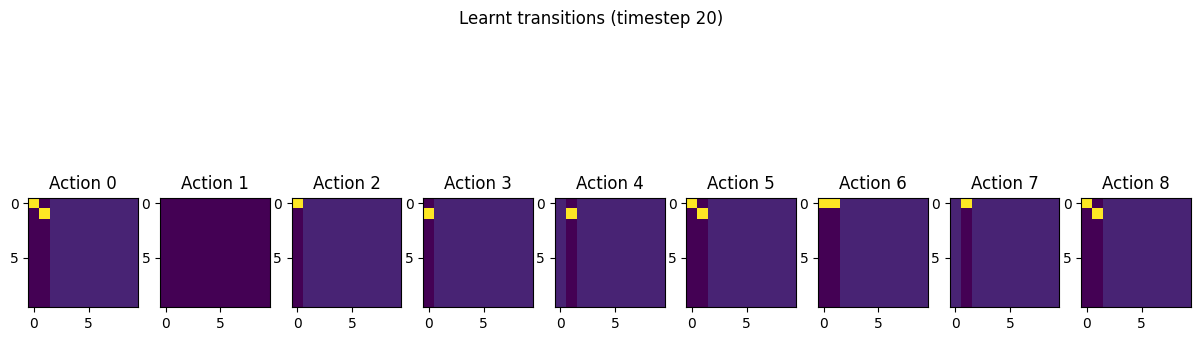

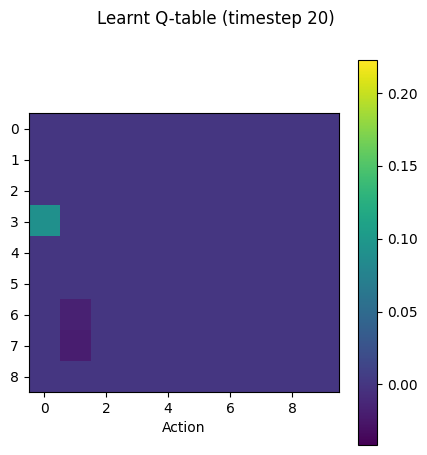

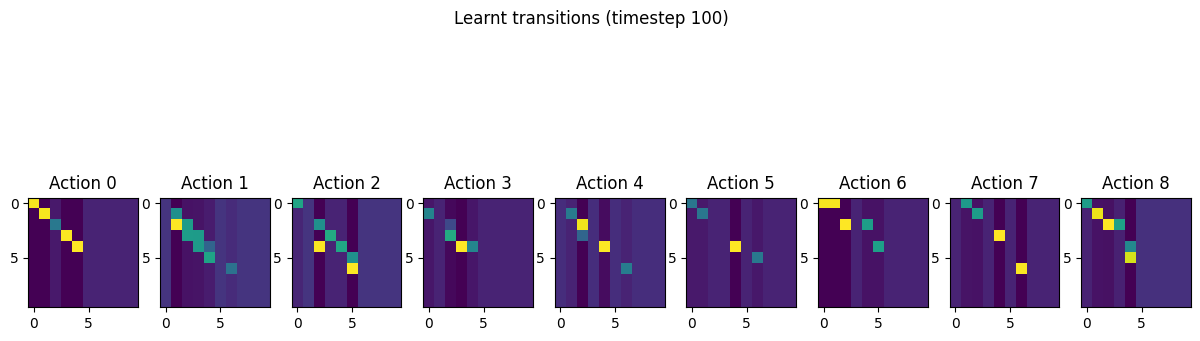

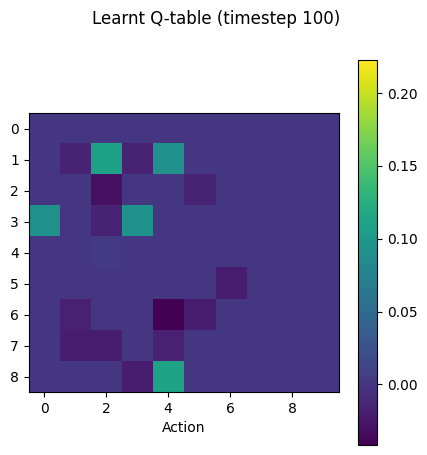

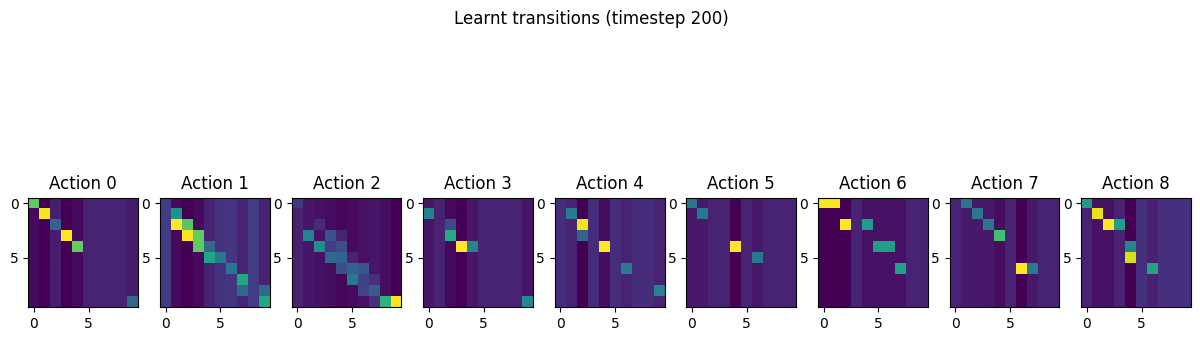

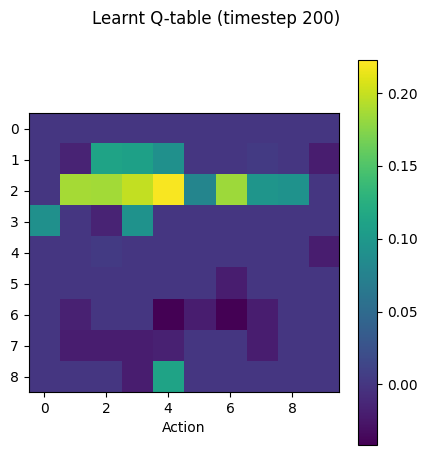

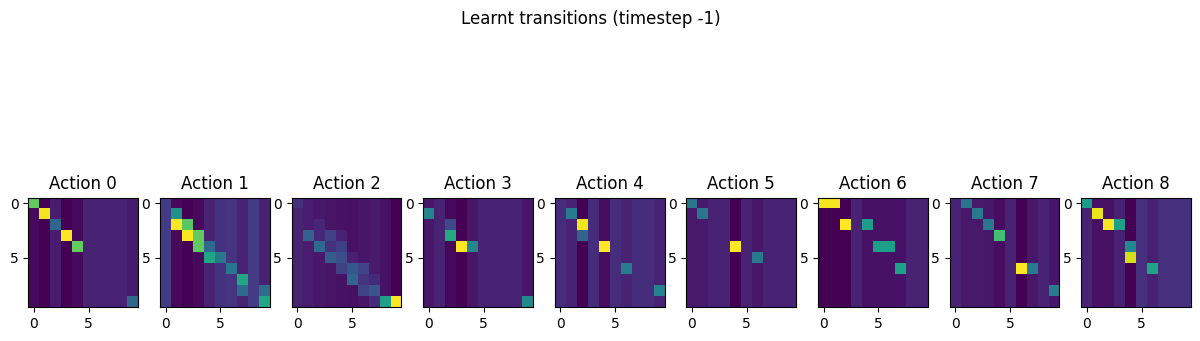

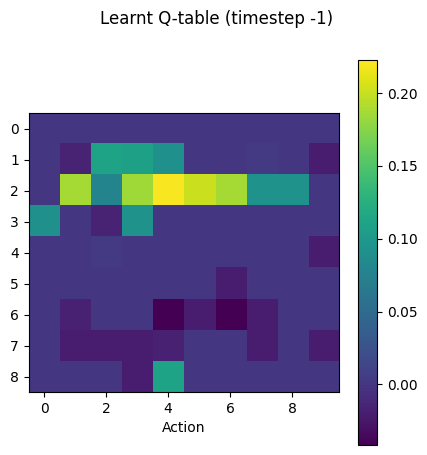

In [6]:

ll_term,predictions,model_variables  = jax.vmap(lambda x : compute_loglikelihood(SYNTHETIC_DATA,static_agent(encoding_function(x)),"sum",True))(all_fin_params)


model_states,other_data = model_variables


# The states of this model are : 
qt,ck,b,acts,stims = model_states

print(acts["angle"].shape)

print(b["angle"][0].shape)


one_training_episode_learnt_transitions = np.reshape(b["angle"][0],(-1,10,10,9))

one_training_episode_qtables = np.reshape(qt["angle"][0],(-1,9,10))

print(one_training_episode_qtables.shape)

# import imageio,PIL

# images = {[]}
# for t in one_training_episode_learnt_transitions.shape[0]:
#     images.append(imageio.imread(filename))
# imageio.mimsave('/path/to/movie.gif', images)
Nactions = one_training_episode_learnt_transitions.shape[-1]

for t in [0,20,100,200,-1]:
    fig,axs = plt.subplots(1,Nactions,figsize=(15,5))
    fig.suptitle("Learnt transitions (timestep {})".format(t))
    for k, ax in enumerate(axs):
        ax.set_title("Action {}".format(k))
        im = ax.imshow(_normalize(one_training_episode_learnt_transitions[t,...,k])[0])
    
    fig,ax = plt.subplots(1,figsize=(5,5))
    fig.suptitle("Learnt Q-table (timestep {})".format(t))
    im = ax.imshow(one_training_episode_qtables[t,...],cmap="viridis",vmin=np.min(one_training_episode_qtables),vmax=np.max(one_training_episode_qtables))
    ax.set_xlabel("State")
    ax.set_xlabel("Action")
    fig.colorbar(im)